# Grundlagen der Künstlichen Intelligenz - Wintersemester 2024/25

# Übung 6: Hidden Markov Models und Markov Decision Processes

---

> 'Grundlagen der künstlichen Intelligenz' im Wintersemester 2024/2025
>
> - T.T.-Prof. Benjamin Schäfer, benjamin.schaefer@kit.edu
> - Prof. Gerhard Neumann, gerhard.neumann@kit.edu

---

In dieser Übung werden wir ein Hidden Markov Model definieren und den Forward/Backward Algorithmus darauf anwenden. Außerdem wollen wir für ein gegebenes MDP die Value Iteration durchführen und eine Policy extrahieren.

### Übungsteam

- Philipp Dahlinger, philipp.dahlinger@kit.edu
- Nicolas Schreiber, nicolas.schreiber@kit.edu
- Sebastian Pütz, sebastian.puetz@kit.edu
- Ulrich Oberhofer, ulrich.oberhofer@kit.edu


# Gruppenabgabe

Die Übungsblätter können in Gruppen von bis zu **3 Studierenden** abgegeben werden. **Jede Person aus der Gruppe muss die finale Version der Abgabe über Ilias hochladen**, es genügt nicht, dass nur eine Person aus der Gruppe dies tut. Es ist prinzipiell möglich, im Laufe des Semesters sich einer neuen Gruppe anzuschließen, sollte sich die eigene Gruppe vorzeitig auflösen. Generell muss jede Gruppe ihre eigene Lösung hochladen, wir werden die Abgaben auf Duplikate überprüfen.

Die Gruppen werden automatisch erfasst, **gebt deshalb die u-Kürzel eurer Gruppenmitglieder in die folgende Zelle ein.** Falls eure Gruppe nur aus 2 Studierenden besteht, oder ihr alleine abgibt, lasst die verbleibenden Felder frei. Hier ein Beispiel für eine Gruppe bestehend aus uabcd und uefgh:

_U-Kürzel der Gruppenmitglieder:_

_Mitglied 1: uabcd_

_Mitglied 2: uefgh_

_Mitglied 3:_


U-Kürzel der Gruppenmitglieder:

Mitglied 1: uqjwv

Mitglied 2: uzrzy

Mitglied 3:


# Auto-grading

Wir nutzen ein auto-grading System, welches eure abgegebenen Jupyter Notebooks automatisch analysiert und über
hidden Tests auf Richtigkeit prüft. Über diese Tests werden die Punkte bestimmt, die ihr für das Übungsblatt erhaltet.

Damit das auto-grading reibungslos funktioniert bitte folgende Dinge beachten:

- Vor dem Abgeben eines Notebooks bitte testen, dass alles von vorne bis hinten ohne Fehler durchläuft.
- Zellen, welche mit "### DO NOT CHANGE ###" markiert sind dürfen weder gelöscht noch bearbeitet werden
- Eure Lösung muss in die richtige Zelle (markiert mit "# YOUR CODE HERE") eingetragen werden.
    - (dabei natürlich den NotImplementedError löschen!)
- Es gibt potentiell scheinbar leere Zellen, die auch mit "### DO NOT CHANGE ###" markiert sind. Auch diese dürfen nicht bearbeitet oder gelöscht werden.
    - Falls dies doch gemacht wird, dann wird das automatische Grading nicht funktionieren und ihr erhaltet keine Punkte.
    - Wir werden hier strikt handeln und keine Ausnahmen machen, falls jemand doch Zellen verändert, die eindeutig als readonly markiert sind!
- Die Jupyter Notebooks haben inline Tests (für euch sichtbar), welche euer Ergebnis auf grobe Richtigkeit überprüfen.
    - Diese sind primär für euch, um Fehler zu erkennen und zu korrigieren.
    - Die inline Tests, die ihr im Notebook sehen könnt, sind allerdings nicht die Tests welche für das Grading verwendet werden!
    - Die inline Tests sind eine notwendige Bedingung, um beim Grading der Aufgabe Punkte zu erhalten!

# **WICHTIG** Abgabe des Notebooks
- Bitte das Jupyter Notebook mit dem ursprünglichen Dateinamen ins Ilias hochladen ("ex_06_hmm_mdp.ipynb")
- Bitte Jupyter Notebook und handgeschriebene PDF einzeln hochladen, nicht als ZIP.
- Bitte darauf achten, dass die Jupyter Notebook Zell-Metadaten erhalten bleiben. Das ist eigentlich immer der Fall,
in wenigen Fällen gab es hier jedoch Probleme. Um auf Nummer Sicher zu gehen bitte das Notebook vor der Abgabe ein Mal
in einem normalen Texteditor öffnen und nach "nbgrader" suchen. Wenn hier dann keine entsprechenden JSON-Einträge auftauchen
dann sind leider die Metadaten verloren gegangen.

# 1. Hidden Markov Models und der Forward / Backward Algorithmus
In dieser Aufgabe werden wir ein Hidden Markov Model (HMM) am Beispiel einer Roboter Lokalisierung definieren und anschließend den Belief über Zeit berechnen.

Wir nehmen an, dass unsere Welt aus 5 vertikal benachbarten Feldern besteht, in einem dieser Felder befindet sich der Roboter. Wir kodieren die aktuelle Position $z_t$ des Roboters als Ganzzahl. Der Zustand (also die Position des Roboters) zum Zeitpunkt $t$ liegt also zwischen $z_t=0$ und $z_t=4$.
Unser Sensor zum Messen des aktuellen Zustands gibt ebenfalls eine Zahl zwischen $y_t=0$ und $y_t=4$ aus. Allerdings ist diese Messung fehlerhaft, wie wir gleich sehen werden.

Wir wissen aus der Vorlesung, dass wir für die Definition eines HMMs drei Größen benötigen:
- Ausgangsverteilung $p(z_0)$: Diese können wir als Vektor der Größe 5 mit Einträgen zwischen 0 und 1 angeben. Die Summe muss 1 ergeben, um eine wohldefinierte Wahrscheinlichkeitsverteilung zu erhalten.
- Transitionsmodell $p(z_{t+1} | z_t)$: Übegangswahrscheinlichkeit von Zustand $z_t$ zu $z_{t+1}$. Dies können wir als $5x5$-Matrix realisieren.
- Beobachtungsmodell $p(y_t| z_t)$: Wahrscheinlichkeit für eine Beobachtung gegebn der aktuellen Position. Diese Modell Können wir ebenfalls als $5x5$-Matrix modellieren.

In [1]:
##### DO NOT CHANGE #####
import numpy as np
import matplotlib.pyplot as plt

##### DO NOT CHANGE #####

Wir nehmen an, dass wir nichts über den initialen Zustand wissen, dementsprechend ist $p(z_0=i) = \frac1 5$ für alle $i=0,...,4$.

In [2]:
##### DO NOT CHANGE #####
# Initial state distribution
p_z0 = np.ones(5) * 0.2
print("p(z_0):", p_z0)

##### DO NOT CHANGE #####

p(z_0): [0.2 0.2 0.2 0.2 0.2]


## 1.1 Transitionsmodell (1 Punkt)
Der Roboter bewegt sich probabilistisch: entweder bleibt er auf seiner aktuellen Position stehen (90% der Fälle),
oder er bewegt sich von Feld $i$ auf Feld $i+1$ (10% der Fälle). Zurück gehen kann er also nicht. Falls der Roboter sich schon auf dem letzten Feld $i=4$ befindet, bewegt er sich für die zukünfiten Zeitpunkte nicht mehr.

Definiere dieses Transitionsmodell als $5x5$ Matrix $T$, so dass gilt:
$$
p(z_{t+1}=j|z_t=i) = T[i,j]
$$

*Hinweis: Beachte, dass die Matrix richtig transponiert ist, siehe dazu die Testwerte in der Zelle darunter.*

In [8]:
def get_transition_model():
    """
    returns: np.array T of shape [5, 5], such that p(z_t+1 = j | z_t = i) = T[i, j]
    """
    T = np.zeros((5, 5))

    # Für die ersten 4 Zeilen (Positionen 0 bis 3)
    for i in range(4):
        T[i, i] = 0.9    # 90% Wahrscheinlichkeit, auf der gleichen Position zu bleiben
        T[i, i+1] = 0.1  # 10% Wahrscheinlichkeit, sich zum nächsten Feld zu bewegen

    # Für die letzte Zeile (Position 4)
    T[4, 4] = 1.0

    return T

In [9]:
##### DO NOT CHANGE #####
# ID: Ex1_1 - possible points: 1

# Tests for 1.1:
transition_model = get_transition_model()
assert isinstance(transition_model, np.ndarray)
assert transition_model.shape == (5, 5)
print("Prob. of State z_t+1 = 3 given z_t = 2:", transition_model[2, 3])
print("Prob. of State z_t+1 = 2 given z_t = 3:", transition_model[3, 2])
print("Prob. of State z_t+1 = 1 given z_t = 1:", transition_model[1, 1])
assert np.isclose(transition_model[2, 3], 0.1)
assert np.isclose(transition_model[4, 2], 0.0)
assert np.isclose(transition_model[1, 1], 0.9)



##### DO NOT CHANGE #####

Prob. of State z_t+1 = 3 given z_t = 2: 0.1
Prob. of State z_t+1 = 2 given z_t = 3: 0.0
Prob. of State z_t+1 = 1 given z_t = 1: 0.9


## 1.2 Beobachtungsmodell (1 Punkt)
Der Sensor ist leider ungenau, um die Position des Roboters zu messen. Ist der Roboter in Zustand $i$, so sagt der Sensor alle Positionen von $0$ bis $i$ mit gleicher Wahrscheinlichkeit voraus. Außerdem misst der Sensor niemals eine Beobachtung $j$, die größer als der aktuelle Zustand $i$ des Roboters ist. Als Formel geschrieben:
$$
p(y_t=j | z_t=i) = \left\{ \begin{array}{ll}
                    \frac 1 {i +1} & j <= i &  \\
                    0 & \, \textrm{sonst} \\
                    \end{array} \right.
$$

Implementiere das Beobachtungsmodell als $5x5$ Matrix H, sodass gilt:
$$
p(y_t=j | z_t=i) = H[i, j]
$$

In [10]:
def get_observation_model():
    H = np.zeros((5, 5))  # Initialisiere eine 5x5-Matrix mit Nullen

    for i in range(5):  # Für jeden Zustand z_t = i
        for j in range(i + 1):  # Für alle möglichen Beobachtungen y_t = j (j <= i)
            H[i, j] = 1 / (i + 1)  # Gleichmäßige Verteilung auf [0, ..., i]

    return H


In [11]:
##### DO NOT CHANGE #####
# ID: Ex1_2 - possible points: 1

# Tests for 1.2:
observation_model = get_observation_model()
assert isinstance(observation_model, np.ndarray)
assert observation_model.shape == (5, 5)
print("Prob. of Observation y_t = 2 given z_t = 1:", observation_model[1, 2])
print("Prob. of Observation y_t = 1 given z_t = 2:", observation_model[2, 1])
assert np.isclose(observation_model[1, 2], 0.0)
assert np.isclose(observation_model[2, 1], 1/3)


##### DO NOT CHANGE #####

Prob. of Observation y_t = 2 given z_t = 1: 0.0
Prob. of Observation y_t = 1 given z_t = 2: 0.3333333333333333


Um sich das HMM besser vorzustellen, ist hier eine Visualisierung. Die x-Achse läuft über Zeit, die y-Achse sind die verschiedenen Zustände. Ein "X" bedeutet, dass sich hier der Roboter zu diesem Zeitpunkt befindet. ein blauer Rahmen eines Kästchen zeigt an, dass diese Position vom Sensor beobachtet wurde.

In [12]:
##### DO NOT CHANGE #####
def get_states_obs(transition_model, observation_model, seed=42, length=50):
    """
    Creates a sequence of states and observations according to the given HMM.
    """
    # In the visualization, we always start in state 0
    current_state = 0
    gth_states = [current_state]

    np.random.seed(seed)

    for step in range(length):
        transition_probs = transition_model[current_state]
        current_state = np.random.choice(len(transition_probs), p=transition_probs)
        gth_states.append(current_state)


    observations = []
    for state in gth_states:
        obs_probs = observation_model[state]
        observations.append(np.random.choice(len(obs_probs), p=obs_probs))

    return gth_states, observations

##### DO NOT CHANGE #####

In [13]:
##### DO NOT CHANGE #####
def visualize_hmm(belief=None, gth_states=None, observations=None):
    T = len(gth_states)
    num_states = 5
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(T, num_states ))

    # Create the grid of red blocks
    for i in range(num_states):
        for j in range(T):
            if belief is not None:
                facecolor =  np.array([1, 0, 0]) *(belief[j, i]) + np.array([1, 1, 1]) * (1 -belief[j, i])  # fill color
            else:
                facecolor = "none"
            rect = plt.Rectangle(
                (j, num_states - i - 1),  # x, y position (invert y for better readability)
                1, 1,  # width, height
                facecolor=facecolor,
                alpha=1,  # transparency level
                edgecolor=None,  # border color
            )
            ax.add_patch(rect)
            if observations is not None:
                if observations[j] == i:
                    linewidth = 2
                    edgecolor = "blue"
                    rect = plt.Rectangle(
                        (j, num_states - i - 1),  # x, y position (invert y for better readability)
                        1, 1,  # width, height
                        facecolor="none",
                        edgecolor=edgecolor,  # border color
                        linewidth=linewidth,
                    )
                    ax.add_patch(rect)
            if gth_states is not None:
                if gth_states[j] == i:
                    # Draw an "X" if it the real position
                    x1, y1 = j, num_states - i - 1  # Bottom-left corner of the rectangle
                    x2, y2 = x1 + 1, y1 + 1  # Top-right corner of the rectangle
                    line1 = plt.Line2D([x1, x2], [y1, y2], color='black', linewidth=0.5)  # First diagonal
                    line2 = plt.Line2D([x1, x2], [y2, y1], color='black', linewidth=0.5)  # Second diagonal
                    ax.add_line(line1)
                    ax.add_line(line2)


    # Set axis limits and labels
    ax.set_xlim(0, T)
    ax.set_ylim(0, num_states)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(T) + 0.5)  # Center labels in grid cells
    ax.set_yticks(np.arange(num_states-1, -1, -1) + 0.5)
    ax.set_xticklabels([f"t={t}" for t in range(T)])
    ax.set_yticklabels([f"State {s}" for s in range(num_states)])

    # Axis labels
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("State Index")

    # Optional: Add gridlines for clarity
    # ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5, which='both')

    # Turn off the axis frame
    ax.set_frame_on(False)

    plt.show()

##### DO NOT CHANGE #####

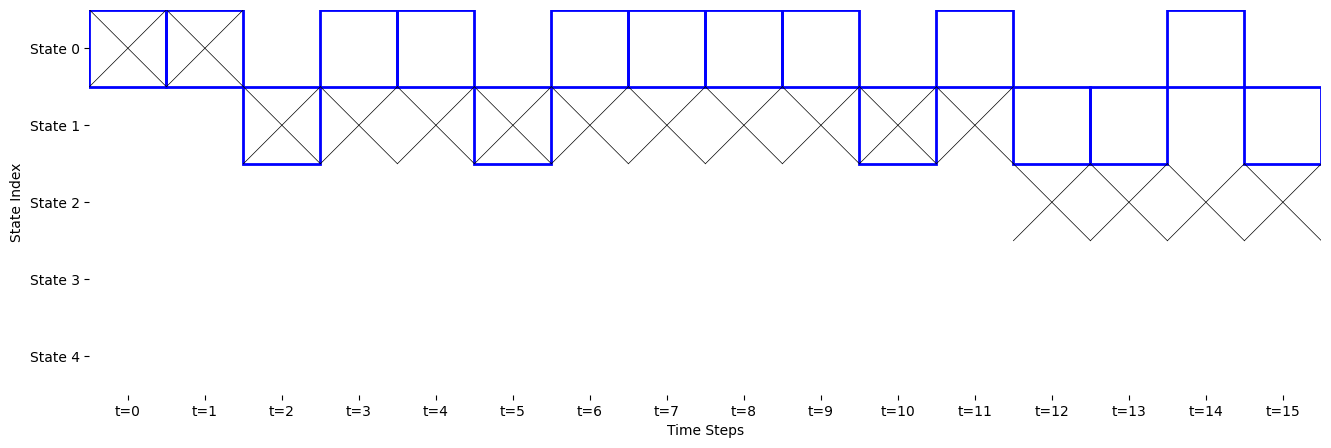

In [16]:
gth_states, observations = get_states_obs(transition_model, observation_model, seed=42, length=15)
visualize_hmm(belief=None, gth_states=gth_states, observations=observations)

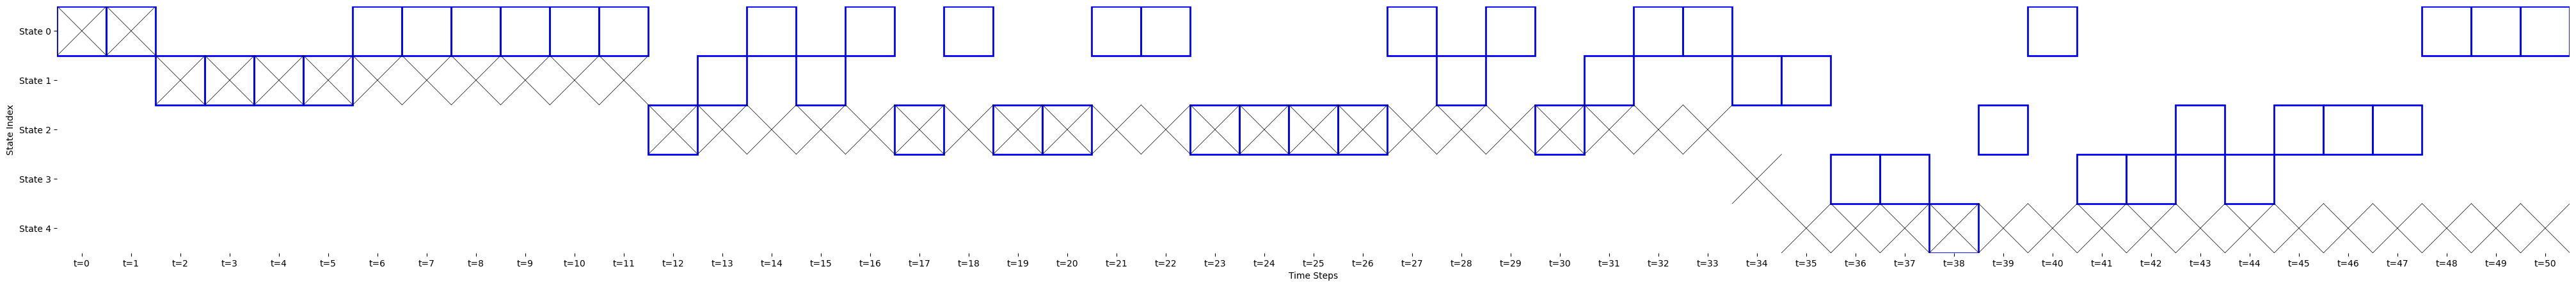

In [17]:
gth_states, observations = get_states_obs(transition_model, observation_model, seed=42, length=50)
visualize_hmm(belief=None, gth_states=gth_states, observations=observations)

## 1.3 Forward Algorithmus (3 Punkte)
Nun wollen wir die Beobachtungen filtern und einen Belief über den aktuellen State gewinnen. Der Algorithmus ist auf Slide 52 der Vorlesung 12 gegeben. Wir fassen alle Alpha-Werte als ein großes Array der Größe `[len(observations), 5]` auf. Es gilt also
$$
\alpha_t(z_t=i) = \text{alpha}[t, i]
$$

Implementiere den Forward Algorithmus in der nächsten Funktion! Gebe sowohl die (unnormalisierten) Alpha-Werte, als auch die normalisierten Belief Werte (auf Slide 52 als $b_t$ definiert) zurück. Fange mit der Initialisierung an ($\alpha_0(z_0) = p(y_0|z_0)p(z_0)$ für alle $z_0 = 0, ..., 4$).

*Hinweis: Du kannst for-loops verwenden, eine komplette Vektorisierung ist nicht verlangt und für dieses Beispiel nicht notwendig.*

In [18]:
def forward_algo(p_z0, transition_model, observation_model, observations):
    """
    Forward Algorithm.
    params:
        p_z0: Prior Belief of the initial state distribution z_0
        transition_model: Output of get_transition_model(), shape [5, 5]
        observation_model: Output of get_observation_model(), shape [5, 5]
        observations: List of observations, length: num_timesteps, values: between 0 and 4. Output of the sensor
    returns:
        Tuple (alpha, b). alpha: np.array of shape [len(observations), 5],
                              b: np.array of shape [len(observations), 5].
    """
    num_timesteps = len(observations)
    alpha = np.zeros((num_timesteps, 5))
    b = np.zeros((num_timesteps, 5))

    # Initialisierung
    alpha[0] = observation_model[:, observations[0]] * p_z0
    b[0] = alpha[0] / np.sum(alpha[0])

    # Forward-Algorithmus
    for t in range(1, num_timesteps):
        for i in range(5):  # für jeden möglichen Zustand
            alpha[t, i] = observation_model[i, observations[t]] * np.sum(transition_model[:, i] * alpha[t-1])

        # Normalisierung für b
        b[t] = alpha[t] / np.sum(alpha[t])

    return alpha, b

In [21]:
##### DO NOT CHANGE #####
# ID: Ex1_3a - possible points: 2

# Tests for 1.3
gth_states, observations = get_states_obs(transition_model, observation_model, seed=42, length=15)
alpha, b = forward_algo(p_z0, transition_model, observation_model, observations)
assert isinstance(alpha, np.ndarray)
assert isinstance(b, np.ndarray)
assert alpha.shape == (len(observations), 5)
assert b.shape == alpha.shape
assert np.all(alpha >= 0)
assert np.all(b >= 0)
assert np.all(b <= 1)



##### DO NOT CHANGE #####

In [22]:
##### DO NOT CHANGE #####
# ID: Ex1_3b - possible points: 1

# Hidden Tests for 1.3

##### DO NOT CHANGE #####

Hier ein paar Visualisierung des gefilterten Belief States: Die Intensität der Färbung gibt die Wahrscheinlichkeit an, dass hier der Roboter sich befindet. Da wir als Prior Verteilung des Zustands keine Annahmen gemacht haben, ist die initiale Verteilung noch sehr uniform. Über die ersten Zeitschritte wird sich der Algorithmus dann zunehmend sicherer, dass sich der Roboter noch im ersten Zustand befindet.

Beachte außerdem, dass z.B. in der ersten Visualisierung von $t=11$ bis $t=17$ der Zustand 2 einen vergleichsweise hohen Belief hat, allerdings Zustand 0 einen Belief von 0 hat. Dies folgt aus der Definition des HMM, da sobald eine Beobachtung von State 1 vorhanden ist, eine Position des Roboters im Zustand 0 ausgeschlossen ist.

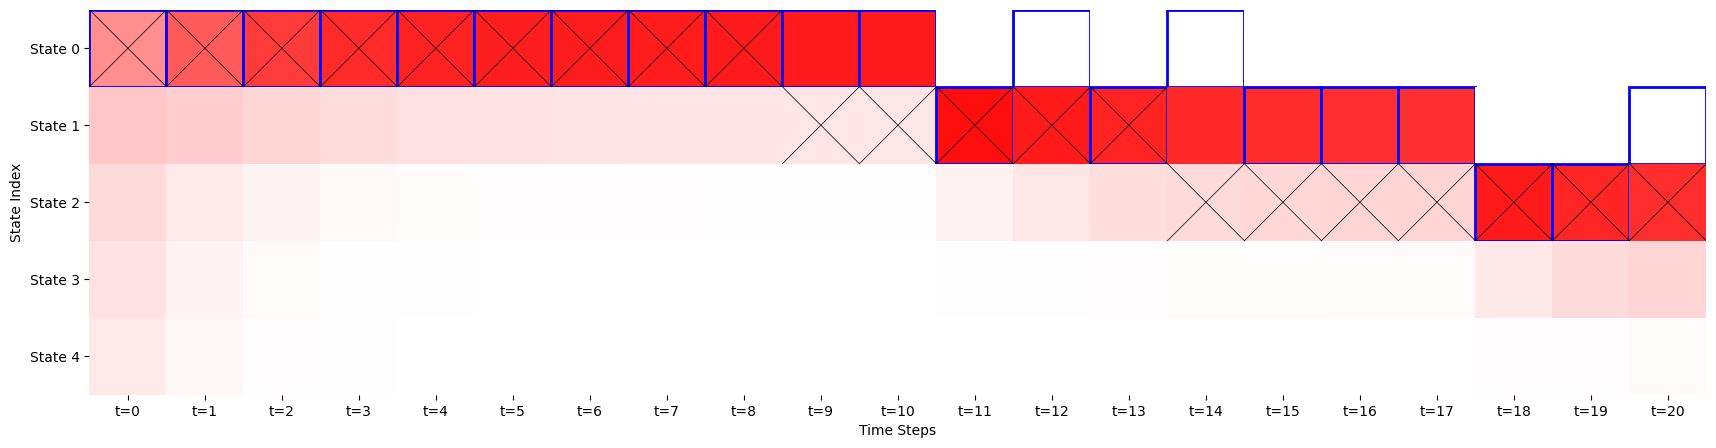

In [23]:
gth_states, observations = get_states_obs(transition_model, observation_model, seed=0, length=20)
alpha, b = forward_algo(p_z0, transition_model, observation_model, observations)
visualize_hmm(belief=b, gth_states=gth_states, observations=observations)

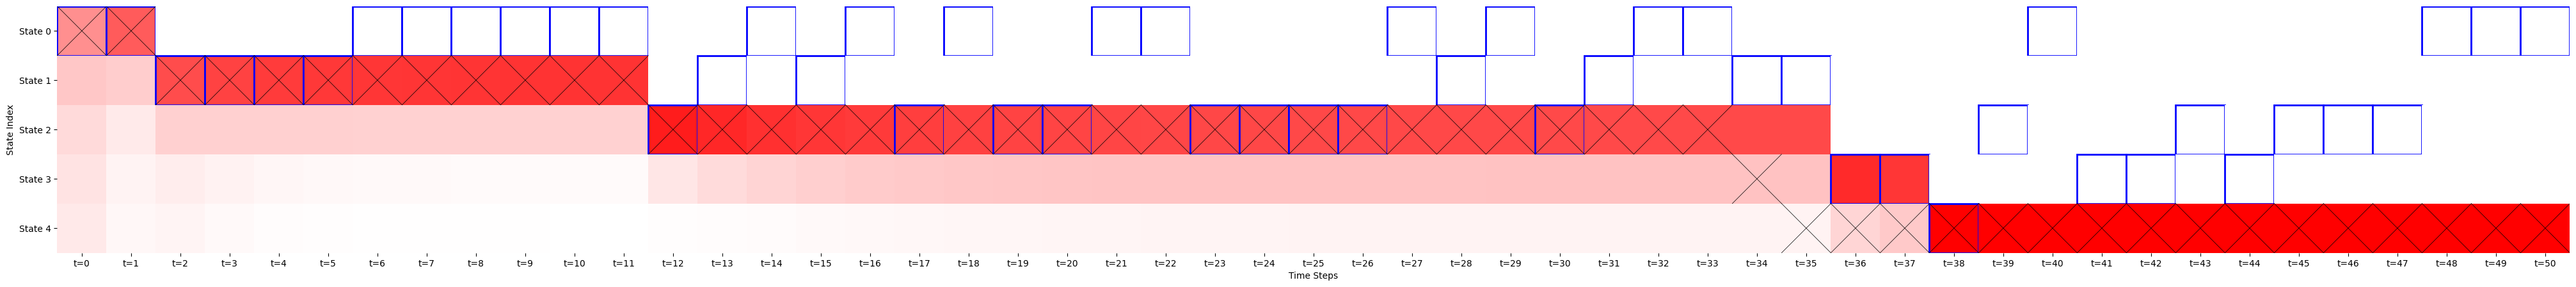

In [24]:
gth_states, observations = get_states_obs(transition_model, observation_model, seed=42, length=50)
alpha, b = forward_algo(p_z0, transition_model, observation_model, observations)
visualize_hmm(belief=b, gth_states=gth_states, observations=observations)

## 1.4 Backward Algorithmus (2 Punkte)
Um eine Glättung durchzuführen, müssen wir den Backward Algorithmus implementieren. Hier die wichtigen Formeln:

Initialisierung: für alle $z_T = 0,...,4$:
    $$\beta_T(z_T) = 1$$
    
Iteration: für $t= T-1, ..., 0$ und $z_t = 0, ..., 4$:
    $$\beta_t(z_t) = \sum_{z_{t+1}=0}^4 p(z_{t+1}| z_t)p(y_t | z_t) \beta_{t+1}(z_{t+1})$$

Implementiere den Backward Algorithmus in der nächste Funktion. Anders als im Forward Algorithmus ist hier keine Normalisierung von $\beta$ verlangt.

In [25]:
def backward_algo(transition_model, obs_model, observations):
    """
    Backward Algorithm.
    params:
        transition_model: Output of get_transition_model(), shape [5, 5]
        observation_model: Output of get_observation_model(), shape [5, 5]
        observations: List of observations, length: num_timesteps, values: between 0 and 4. Output of the sensor
    returns:
        beta: np.array of shape [len(observations), 5].

    """
    num_timesteps = len(observations)
    beta = np.zeros((num_timesteps, 5))

    # Initialisierung
    beta[-1] = np.ones(5)  # βT(zT) = 1 für alle zT

    # Backward-Iteration
    for t in range(num_timesteps - 2, -1, -1):  # von T-1 bis 0
        for z_t in range(5):  # für jeden möglichen Zustand z_t
            for z_t_plus_1 in range(5):  # für jeden möglichen Zustand z_{t+1}
                beta[t, z_t] += (transition_model[z_t, z_t_plus_1] *
                                 obs_model[z_t_plus_1, observations[t+1]] *
                                 beta[t+1, z_t_plus_1])

    return beta

In [26]:
##### DO NOT CHANGE #####
# ID: Ex1_4 - possible points: 2

# Tests for 1.4
gth_states, observations = get_states_obs(transition_model, observation_model, seed=42, length=15)
beta = backward_algo(transition_model, observation_model, observations)
assert isinstance(beta, np.ndarray)
assert beta.shape == (len(observations), 5)
assert np.all(beta >= 0)



##### DO NOT CHANGE #####

## 1.5 Forward-Backward Algorithmus / Glättung (2 Punkte)
Nun können wir beide Schritte zusammen führen und eine Glättung der gemessenen Daten bestimmen, welche zu jedem Zeitpunkt sowohl vergangene als auch zukünftige Zeitpunkte mit einbezieht. Wie auf Folie 56 hergeleitet, ist der finale Belief gegeben als das normalisierte Produkt der Alpha und Beta Werte:
$$
b_t(z_t) = \frac {\alpha_t(z_t)\beta_t(z_t)}{\sum_{z_t=0}^4 \alpha_t(z_t)\beta_t(z_t)}
$$

Implementiere dies in der nächsten Funktion!

In [27]:
def forward_backward_algo(p_z0, transition_model, obs_model, observations):
    """
    Forward-Backward Algorithm. The filtered result (forward_b) will also be returned, but we don't need it
    as an intermediate value.
    params:
        p_z0: Prior Belief of the initial state distribution z_0
        transition_model: Output of get_transition_model(), shape [5, 5]
        observation_model: Output of get_observation_model(), shape [5, 5]
        observations: List of observations, length: num_timesteps, values: between 0 and 4. Output of the sensor
    returns:
        Tuple (belief, forward_b). belief: np.array of shape [len(observations), 5],
                                           Ouptut of the Forward-Backward Algo. (b_t(z_t) in the above equation.)
                                   forward_b: np.array of shape [len(observations), 5],
                                           Normalized output of the Forward Algo.
    """
    alpha, forward_b = forward_algo(p_z0, transition_model, obs_model, observations)
    beta = backward_algo(transition_model, obs_model, observations)
    belief = np.zeros_like(alpha)
    for t in range(len(observations)):
        unnormalized_belief = alpha[t] * beta[t]
        belief[t] = unnormalized_belief / np.sum(unnormalized_belief)

    return belief, forward_b

In [28]:
##### DO NOT CHANGE #####
# ID: Ex1_5 - possible points: 2

# Tests for 1.5
gth_states, observations = get_states_obs(transition_model, observation_model, seed=42, length=15)
belief, forward_b = forward_backward_algo(p_z0, transition_model, observation_model, observations)
assert isinstance(belief, np.ndarray)
assert isinstance(forward_b, np.ndarray)
assert np.shape(belief) == (len(observations), 5)
assert np.shape(forward_b) == (len(observations), 5)
assert np.all(belief >= 0)
assert np.all(belief <= 1)


##### DO NOT CHANGE #####

In der finalen Visualisierung können wir den Filter mit der Glättung vergleichen. Wir sollten sehen, dass die  uniforme Prior Verteilung in der Glättung komplett verdrängt wurde, da aufgrund der zukünftigen Daten nur $z_t=0$ als Startzustand plausibel ist. Außerdem ist die geglättete Verteileung schärfer, der Algorithmus ist sich weniger unsicher, was der aktuelle Zustand ist.

Filtering:


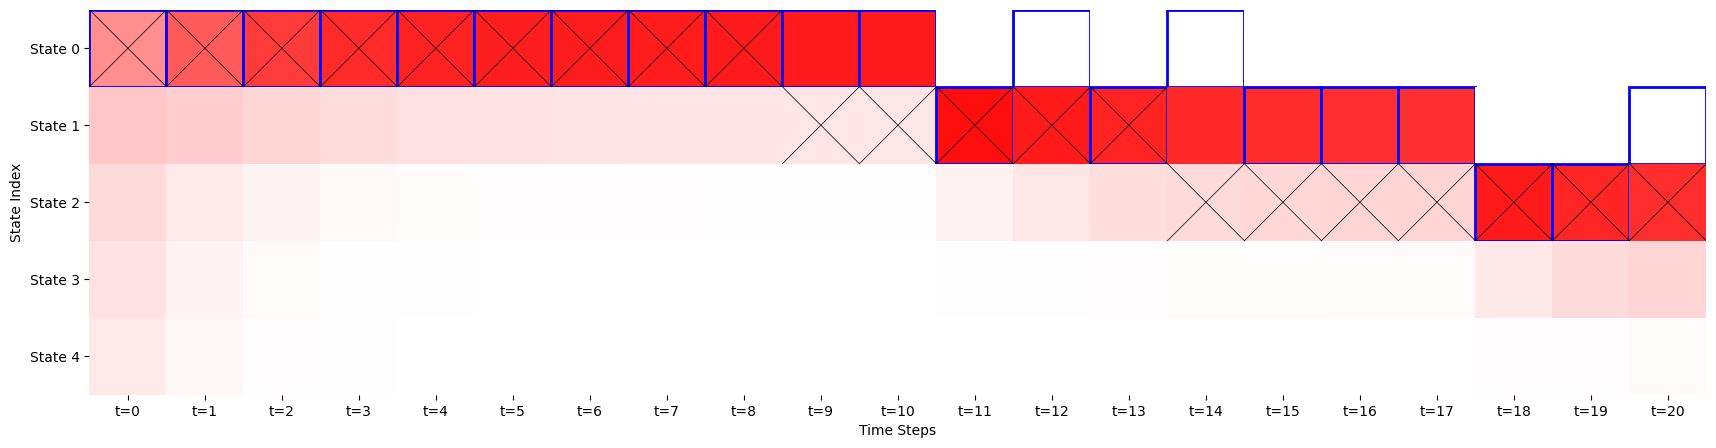

Smoothing:


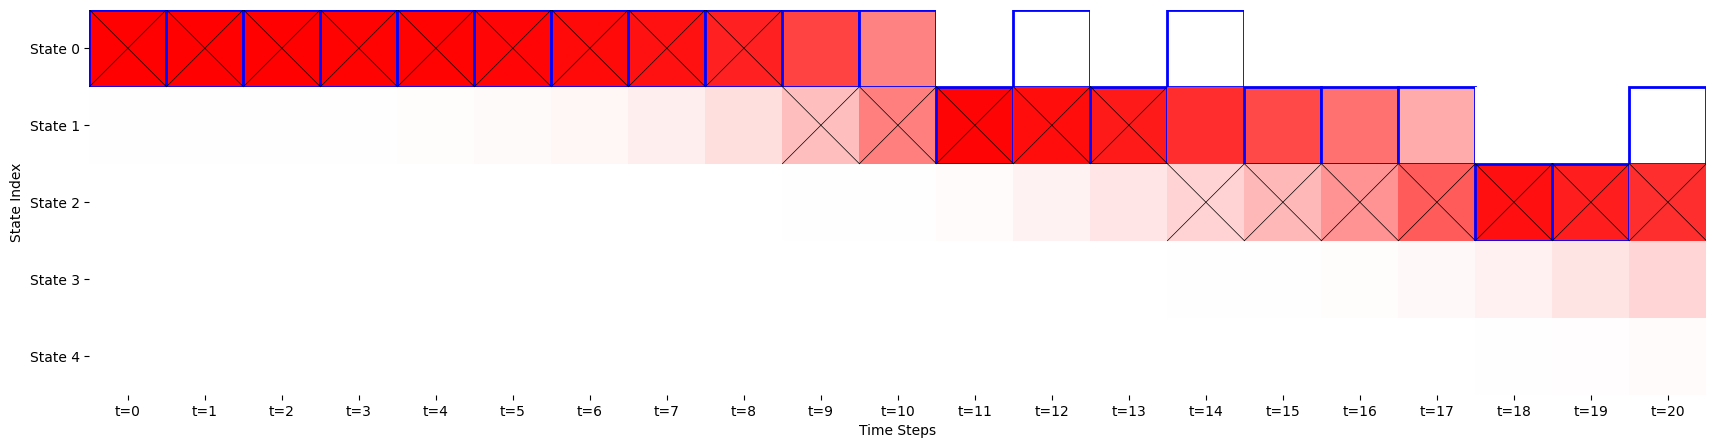

In [29]:
gth_states, observations = get_states_obs(transition_model, observation_model, seed=0, length=20)
belief, forward_b = forward_backward_algo(p_z0, transition_model, observation_model, observations)
print("Filtering:")
visualize_hmm(belief=forward_b, gth_states=gth_states, observations=observations)
print("Smoothing:")
visualize_hmm(belief=belief, gth_states=gth_states, observations=observations)

Filtering:


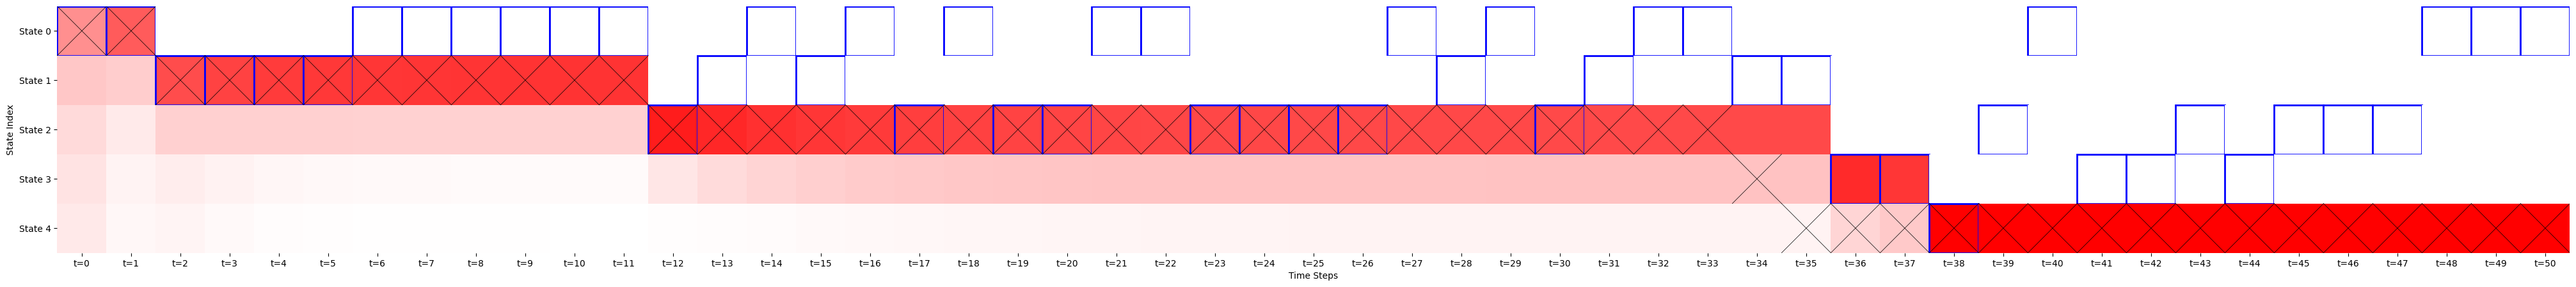

Smoothing:


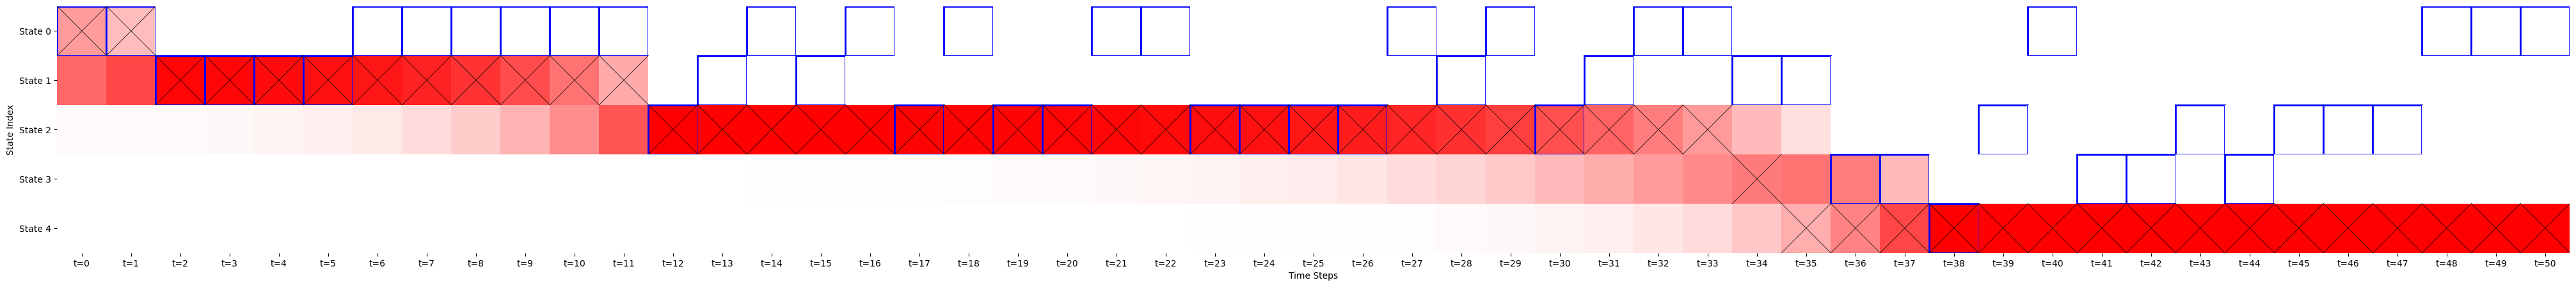

In [30]:
gth_states, observations = get_states_obs(transition_model, observation_model, seed=42, length=50)
belief, forward_b = forward_backward_algo(p_z0, transition_model, observation_model, observations)
print("Filtering:")
visualize_hmm(belief=forward_b, gth_states=gth_states, observations=observations)
print("Smoothing:")
visualize_hmm(belief=belief, gth_states=gth_states, observations=observations)

# 2 MDPs
(Für Context, zunächst Aufgabe 2 auf Übungsblatt durcharbeiten)

Nach einer Weile findet ihr in einer weiteren Kiste im Lagerraum einige andere Tamagotchi Modelle, der Geschäftsmann scheint ein Sammler gewesen zu sein. Jetzt willst du nachdem du für Fillibert schon mehrere Iterationen der Value-Iteration händisch gerechnet hast, das ganze etwas automatisieren und diese implementieren. Die anderen Tamagotchi funktionieren zum Glück gleich wie Fillibert, haben die gleichen States, und Aktionen, nur die Wahrscheinlichkeiten und Rewards sind anders.

Perfekt, dann können wir das ganze erstmal mit den Daten von Fillibert testen!

Hinweis:
- Wir stellen die State-, Action-, Zustandsübergangs- und Reward-Definitionen bereit. Du musst nur die Value Iteration implementieren


In [31]:
##### DO NOT CHANGE #####
# imports
import numpy as np

##### DO NOT CHANGE #####

In [32]:
##### DO NOT CHANGE #####
# 1) Definition: Zustände, Aktionen
states = ["happy", "tired", "dead"]
actions = ["play", "sleep"]
state_idx = {s: i for i, s in enumerate(states)}
action_idx = {a: i for i, a in enumerate(actions)}

# Übergangswahrscheinlichkeiten P(s' | s, a)
# p[s, a, s'] = Wahrscheinlichkeit, von Zustand s durch Aktion a nach Zustand s' zu gelangen
p = np.zeros((len(states), len(actions), len(states)))

# Rewards R(s, a) (Zustands-/Aktions-abhängig, unabhängig von s')
r = np.zeros((len(states), len(actions)))

# 2) Modellieren der MDP-Übergänge und Rewards:

# Zustand happy (index 0)
p[state_idx["happy"], action_idx["play"], state_idx["happy"]] = 0.9
p[state_idx["happy"], action_idx["play"], state_idx["tired"]] = 0.1
r[state_idx["happy"], action_idx["play"]] = 16

p[state_idx["happy"], action_idx["sleep"], state_idx["happy"]] = 1.0
r[state_idx["happy"], action_idx["sleep"]] = 0

# Zustand tired (index 1)
p[state_idx["tired"], action_idx["play"], state_idx["dead"]] = 1.0
r[state_idx["tired"], action_idx["play"]] = -100  # Sofortiger Tod

p[state_idx["tired"], action_idx["sleep"], state_idx["tired"]] = 0.25
p[state_idx["tired"], action_idx["sleep"], state_idx["happy"]] = 0.75
r[state_idx["tired"], action_idx["sleep"]] = 0

# Zustand dead (index 2) – absorbierender Zustand
p[state_idx["dead"], action_idx["play"], state_idx["dead"]] = 1.0
p[state_idx["dead"], action_idx["sleep"], state_idx["dead"]] = 1.0
r[state_idx["dead"], :] = 0  # Keine Belohnung mehr

##### DO NOT CHANGE #####

### 2.1 Value Iteration (2 Punkte)

**Aufgabe:**
Implementiere in folgender Zelle einen Value-Iteration-Algorithmus, der ausgehend von einer anfänglichen Value-Funktion $V_0(s)=0\forall s$ die optimalen Werte für jeden Zustand berechnet.

Hier nochmal die Definition der Value Funktion: $$V^\ast(s) = \max_a Q^\ast(s, a)$$ mit $$Q^\ast(s, a) = r(s, a) + \gamma \sum_{s'} P(s' \mid s, a) \, V^\ast(s')$$

Hinweis:
- Wir stellen die State-, Action-, Zustandsübergangs- und Reward-Definitionen bereit. Du musst nur die Value Iteration implementieren

In [33]:
# 3) Value Iteration
def value_iteration(p, r, num_iterations, gamma=0.7):
    """
    Performs the Value Iteration algorithm to compute the optimal state-value function.

    Parameters:
    ----------
    p : ndarray
        Transition probabilities (n_states, n_actions, n_states).
    r : ndarray
        Rewards (n_states, n_actions).
    num_iterations : int
        Number of iterations to run.
    gamma : float, optional
        Discount factor (default: 0.7).

    Returns:
    -------
    V : ndarray
        Optimal value function (n_states).
    """

    n_states, n_actions = r.shape
    V = np.zeros(n_states)  # initial V(s)=0

    for i in range(num_iterations):
        # Kopie des bisherigen V, damit wir V updaten können aber noch die vorherigen Values
        # für die Updateberechnung nutzen zu können
        V_old = V.copy()

        for s in range(n_states):
            # Berechne Q*(s,a) für alle Aktionen
            Q_sa = r[s] + gamma * np.sum(p[s] * V_old, axis=1)

            # Wähle die Aktion mit dem maximalen Q-Wert
            V[s] = np.max(Q_sa)

    return V

In der folgenden Zelle wird eure `value_iteration` Implementierung genutzt um die Value-Funktion für 2 Iterationen zu berechnen.

Selbsttest für euch: Sind die Resultate die gleichen wie bei eurer händischen Berechnung für das Arbeitsblatt?

In [34]:
##### DO NOT CHANGE #####
# ID: Ex2_1 - possible points: 2

# Hauptprogramm: Führe Value Iteration aus und bestimme Policy
V_opt = value_iteration(p, r, num_iterations=2, gamma=0.7)

print("Optimale Werte (Value Function):")
for i, val in enumerate(V_opt):
    print(f"Zustand {states[i]}: V* = {val:.2f}")


##### DO NOT CHANGE #####

Optimale Werte (Value Function):
Zustand happy: V* = 26.08
Zustand tired: V* = 8.40
Zustand dead: V* = 0.00


### 2.2 Optimal Policy (1 Punkt)

**Aufgabe:**
Implementiere in folgender Zelle eine Funktion, die basierend auf einer gegebenen Value-Funktion \( V \) die optimale Policy für jeden Zustand berechnet.

Hier nochmal die Definition der optimalen Policy:  
$$\pi^\ast(s) = \arg\max_a Q^\ast(s, a)$$  
mit  
$$
Q^\ast(s, a) = r(s, a) + \gamma \sum_{s'} P(s' \mid s, a) \, V(s')
$$

Hinweis:
- Verwende die bereitgestellten State-, Action-, Reward- und Zustandsübergangswahrscheinlichkeiten.  
- Die Funktion soll als Eingabe die Value-Funktion \( V \), die Zustandsübergangswahrscheinlichkeiten $P$, die Rewards $R$ und den Diskontfaktor $\gamma$ erhalten.  
- Berechne die $Q$-Werte für jeden Zustand und jede Aktion und extrahiere die Aktion mit dem höchsten $Q$-Wert für jeden Zustand.

In [35]:
def extract_policy(V, p, r, gamma=0.7):
    """
    Extracts the optimal policy given a value function.

    Parameters:
    ----------
    V : ndarray
        State-value function (n_states).
    p : ndarray
        Transition probabilities (n_states, n_actions, n_states).
    r : ndarray
        Rewards (n_states, n_actions).
    gamma : float, optional
        Discount factor (default: 0.7).

    Returns:
    -------
    policy : ndarray
        Optimal policy (n_states), where each entry is the index of the best action.
    """

    n_states, n_actions = r.shape
    policy = np.zeros(n_states, dtype=int)

    for s in range(n_states):
        # Berechne Q*(s,a) für alle Aktionen
        Q_sa = r[s] + gamma * np.sum(p[s] * V, axis=1)

        # Wähle die Aktion mit dem maximalen Q-Wert
        policy[s] = np.argmax(Q_sa)

    return policy


In der folgenden Zelle wird eure `extract_policy` Implementierung genutzt um die optimale Policy der eben berechneten Value-Funktion.

Selbsttest für euch: Sind die Resultate die gleichen wie bei eurer händischen Berechnung für das Arbeitsblatt?

In [36]:
##### DO NOT CHANGE #####
# ID: Ex2_2 - possible points: 1

policy_opt = extract_policy(V_opt, p, r, gamma=0.7)

print("\nOptimale Strategie (Policy):")
for i, act_i in enumerate(policy_opt):
    print(f"Zustand {states[i]} --> Aktion '{actions[act_i]}'")


##### DO NOT CHANGE #####


Optimale Strategie (Policy):
Zustand happy --> Aktion 'play'
Zustand tired --> Aktion 'sleep'
Zustand dead --> Aktion 'play'


# Zusammenfassung

Dies war das Notebook über Hidden Markov Models und Markov Decision Processes. Man kann aus den Aufgaben vor allem herausziehen, dass HMMs ideal sind, um Zustände basierend auf unsicheren Beobachtungen zu schätzen, und dass der Forward-Backward-Algorithmus dabei eine zentrale Rolle spielt. Bei den MDPs zeigt die Value Iteration klar, wie man optimale Strategien für Entscheidungsprobleme ermittelt, selbst in komplexen Szenarien mit unsicheren Übergängen.

Vergesst nicht die Theorie-Aufgabe auf dem Übungsblatt!